# DATASCI 347: Machine Learning (Fall 2025)
## Instructor: Alexander Williams Tolbert
# Lecture: LASSO Classification and Text Mining

---

## Setup: Uploading Dataset to Google Colab

Before we begin our analysis, we need to upload our dataset to the Google Colab environment. Google Colab is a cloud-based platform that provides free access to computing resources, but it doesn't have direct access to files on your local computer. We must explicitly upload any data files we want to analyze.

The dataset we'll use is called `yelp_subset.csv`, which contains 100,000 restaurant reviews from Yelp collected in 2014. Each review includes the text of the review, a star rating (1-5), and various metadata about the review and reviewer.

In [ ]:
from google.colab import files  # 'from' keyword imports specific function; 'import' loads module
uploaded = files.upload()  # '=' assigns result to variable; '.upload()' method opens file chooser dialog
# The parentheses () call the function
# 'files.upload()' uses dot notation to access the upload method from the files module

Saving yelp_subset.csv to yelp_subset.csv


### Understanding the Upload Process

Let's break down what just happened:

**Syntax Breakdown:**
- The `from` keyword allows us to import a specific component from a module
- The `import` keyword loads Python code from external libraries
- The `=` operator assigns the result of the right side to the variable name on the left
- The `.` (dot) operator accesses attributes or methods of an object
- The `()` parentheses execute a function or method

**What Happens in Memory:**
When you execute `files.upload()`, Colab creates a dialog box in your browser. When you select and upload a file, Colab temporarily stores it in the session's working directory. The `uploaded` variable becomes a dictionary where keys are filenames and values are the file contents in bytes.

**After Upload:**
Once uploaded, files remain accessible during your Colab session but will be deleted when the runtime disconnects. You can read the uploaded CSV file using pandas: `pd.read_csv("yelp_subset.csv")`.

## Installing and Importing Required Libraries

Text mining and machine learning require specialized tools that aren't included in Python's standard library. We need to install additional packages that provide functions for natural language processing, statistical modeling, and visualization.

The packages we'll use are:
- **pandas**: For data manipulation and analysis
- **numpy**: For numerical computing and array operations
- **nltk**: Natural Language Toolkit for text processing
- **scikit-learn**: Machine learning algorithms including LASSO
- **wordcloud**: For creating word cloud visualizations
- **matplotlib**: For plotting and visualization

In [ ]:
!pip install nltk wordcloud  # '!' executes shell command in Jupyter; 'pip install' downloads packages
# The exclamation point allows us to run terminal commands from within the notebook

### Understanding Package Installation

**The `!` Prefix:**
In Jupyter notebooks, the `!` prefix allows you to execute shell (terminal) commands. Without it, Jupyter would try to interpret `pip install nltk` as Python code, which would fail.

**The `pip` Command:**
`pip` is Python's package installer. It downloads packages from the Python Package Index (PyPI), a repository of over 400,000 open-source Python packages. When you run `pip install`, it:
1. Searches PyPI for the package
2. Downloads the package and its dependencies
3. Installs them in your Python environment

**Multiple Packages:**
You can install multiple packages in one command by listing them with spaces: `pip install package1 package2 package3`.

In [ ]:
import pandas as pd  # 'import' loads module; 'as' creates alias for shorter reference
import numpy as np  # 'np' is conventional short name for numpy
import nltk  # Natural Language Toolkit - no alias needed, name is short
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # Import specific classes
from sklearn.linear_model import LogisticRegression  # Import logistic regression class
from sklearn.model_selection import train_test_split, cross_val_score  # Import splitting functions
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve  # Import evaluation metrics
from wordcloud import WordCloud  # Import word cloud generator class
import matplotlib.pyplot as plt  # 'pyplot' is matplotlib's plotting interface
import warnings  # Module for controlling warning messages
warnings.filterwarnings('ignore')  # '.filterwarnings()' method with 'ignore' suppresses warnings

# Download required NLTK data
nltk.download('stopwords')  # '.download()' method fetches data; downloads list of common words
nltk.download('punkt')  # Downloads tokenizer data for splitting text into words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Understanding Import Statements and Aliases

**Import Syntax Variants:**

1. **`import module`**: Imports entire module; access with `module.function()`
2. **`import module as alias`**: Same as above but creates shorthand; access with `alias.function()`
3. **`from module import item`**: Imports specific item; access directly as `item()`

**Why Use Aliases:**
- `pd` for pandas: The name "pandas" is longer to type repeatedly
- `np` for numpy: Standard convention recognized by all Python data scientists
- `plt` for pyplot: Makes code more concise when creating many plots

**Dot Notation Hierarchy:**
When you see `sklearn.feature_extraction.text.CountVectorizer`, you're navigating a module hierarchy:
- `sklearn`: Main package
- `feature_extraction`: Submodule for converting raw data to features
- `text`: Sub-submodule specifically for text data
- `CountVectorizer`: Class that converts text to word frequency matrix

**NLTK Downloads:**
NLTK requires separate data downloads because the package itself is just code. The data (like stopword lists and tokenization rules) is stored separately to keep the initial package size small. These downloads happen once and are cached for future sessions.

# 1. Text Mining - Modern Data Mining

## Objectives

In modern data mining, we frequently encounter situations where text contains important, useful information about a response of interest. Text data is fundamentally different from traditional numerical data because it consists of unstructured sequences of words that don't have inherent numerical meanings.

Consider these questions:
- Can we predict how much someone likes a movie based on their written review?
- Can we determine if a restaurant review is positive or negative?
- Can we classify product reviews as helpful or unhelpful?

To answer these questions, we need to convert text into numbers that machine learning algorithms can process. One simple but effective approach is the **bag of words** method, which converts raw text data into a numeric matrix. Here's how it works:

1. We transform each text document into a vector representing the frequency of each word
2. Each unique word becomes a column (feature) in our data matrix
3. Each document becomes a row, with values indicating how many times each word appears

The bag of words approach can be extended using $n$-gram techniques (looking at sequences of $n$ consecutive words) to account for word ordering and context. Once we have this numeric representation, we can apply existing statistical methods like LASSO regression to extract information or make predictions.

### Mathematical Framework

If we have $d$ documents and a vocabulary of $V$ unique words, we create a matrix $\mathbf{X} \in \mathbb{R}^{d \times V}$ where:
- $X_{ij}$ = frequency of word $j$ in document $i$
- Most entries are zero (the matrix is **sparse**) because most documents use only a small subset of all possible words

This lecture uses a Yelp restaurant review case study to demonstrate text mining techniques. We will:
1. Transform text into a word frequency matrix
2. Build a classifier using LASSO logistic regression
3. Conduct sentiment analysis to identify positive and negative words
4. Create word clouds to visualize important words

# 2. Introduction to Case Study: Yelp Reviews

## Background

Founded in 2004, Yelp is a platform that hosts reviews for various services including restaurants, salons, movers, and cleaners. People rely on these reviews and ratings to make decisions about where to eat, which movies to watch, and which doctors to visit.

## Research Question

**Goal:** How are text reviews related to star ratings? How well can we predict star rankings based solely on the text content of reviews?

This question is important because:
- Many platforms have text reviews but no numerical ratings
- Understanding the relationship helps us automate sentiment analysis
- The techniques can be applied to other domains (stock market prediction from news, product recommendation from comments, etc.)

## Dataset Description

We will use a sample of 100,000 restaurant reviews from 2014 (the original dataset contains over 1 million reviews). Each review includes:

- **user_id**: Unique identifier for the reviewer
- **review_id**: Unique identifier for the review
- **text**: The actual review content (our main predictor)
- **stars**: Rating from 1 to 5 (our response variable)
- **date**: When the review was written
- **business_id**: Unique identifier for the restaurant
- **votes.cool**, **votes.funny**, **votes.useful**: Community feedback metrics

**Data Source:** The complete Yelp dataset is available at https://www.yelp.com/dataset

## Analysis Roadmap

1. **Exploratory Data Analysis (EDA)**: Understand the structure and distribution of our data
2. **Data Cleaning and Transformation**: Convert text into a word frequency matrix
3. **Model Building**: Use LASSO and logistic regression for classification
4. **Visualization**: Create word clouds showing positive and negative words
5. **Prediction and Evaluation**: Assess model performance on test data

# 3. LASSO for Classification

## 3.1 LASSO in Logistic Regression

The regularization techniques used in regression are readily applied to classification problems. Here we will penalize the coefficients while maximizing the likelihood function or minimizing the negative log likelihood function.

For a given $\lambda$ we minimize the negative log-likelihood divided by $n$ (Entropy):

$$\min_{\beta_0, \beta_1, \ldots, \beta_p} \frac{-\log(\text{Lik}(\beta))}{n} + \lambda \{|\beta_1| + |\beta_2| + \ldots + |\beta_p|\}$$

The first term measures how well the model fits the data (deviance), and the second term is the $L_1$ penalty that encourages sparsity by shrinking coefficients toward zero.

Similarly we obtain the solution for elastic net using the general penalty function:

$$\left(\frac{1-\alpha}{2}\right)\|\beta\|_2^2 + \alpha \|\beta\|_1$$

where:
- $\|\beta\|_1 = |\beta_1| + |\beta_2| + \ldots + |\beta_p|$ is the $L_1$ norm (LASSO penalty)
- $\|\beta\|_2^2 = \beta_1^2 + \beta_2^2 + \ldots + \beta_p^2$ is the squared $L_2$ norm (Ridge penalty)
- $\alpha \in [0,1]$ controls the mix: $\alpha=1$ gives pure LASSO, $\alpha=0$ gives pure Ridge

### Why LASSO for Text Data?

Text data creates extremely high-dimensional problems. With 100,000 reviews and thousands of unique words, we have:
- **High dimensionality**: $p$ (number of predictors) $>>$ $n$ (number of observations)
- **Sparsity**: Most words appear in very few documents
- **Multicollinearity**: Many words are correlated (synonyms, related concepts)

LASSO is ideal because it:
1. Automatically selects important features (words) by setting irrelevant coefficients to exactly zero
2. Handles the $p >> n$ situation that would make ordinary logistic regression fail
3. Creates interpretable models by identifying the most predictive words

### Implementation Details

In Python's scikit-learn, we:
- Use `LogisticRegression` with `penalty='l1'` for LASSO
- Use `penalty='elasticnet'` for elastic net (requires setting the `l1_ratio` parameter)
- Choose $\lambda$ (called `C` in scikit-learn, where $C = 1/\lambda$) via cross-validation
- Can minimize different criteria: Deviance (default), AUC, or misclassification error

The default is to minimize cross-validated deviance, which means we try to minimize the negative log-likelihood function.

# 4. Exploratory Data Analysis (EDA)

## 4.1 Reading the Data

We begin by loading our dataset and examining its structure. Understanding the data is crucial before any analysis - we need to know what variables we have, what types they are, and what their distributions look like.

We'll read the data using pandas, Python's primary library for data manipulation. Pandas provides DataFrame objects, which are like spreadsheets in Python - they have rows (observations) and columns (variables).

In [ ]:
# Read the CSV file into a pandas DataFrame
data_all = pd.read_csv('yelp_subset.csv')  # 'pd.read_csv()' function reads CSV file
# The string 'yelp_subset.csv' is the filename in quotes
# The result is assigned to variable 'data_all' using '='

# Check dimensions (rows and columns)
print(data_all.shape)  # '.shape' attribute returns tuple (n_rows, n_columns)
# 'print()' function displays output; it takes one argument in parentheses

# Display memory usage
memory_mb = data_all.memory_usage(deep=True).sum() / (1024**2)  # Calculate memory in MB
# '.memory_usage()' method with 'deep=True' parameter gets detailed memory info
# '.sum()' adds up memory across all columns
# '/' divides; '**' is exponentiation operator (1024^2 converts bytes to MB)
print(f"Memory usage: {memory_mb:.2f} MB")  # f-string with curly braces {} for variable insertion
# ':.2f' formats float to 2 decimal places

(100000, 10)
Memory usage: 105.36 MB


### Understanding DataFrames and Data Loading

**What is a DataFrame?**
A pandas DataFrame is Python's primary data structure for tabular data. Think of it as:
- A spreadsheet with labeled rows and columns
- Each column can have a different data type (integers, floats, strings, dates)
- Rows are observations, columns are variables

**The `.shape` Attribute:**
The `.shape` attribute returns a tuple `(n_rows, n_columns)`. For example, if `data_all.shape` returns `(100000, 10)`, this means:
- 100,000 rows (reviews in our case)
- 10 columns (variables like user_id, text, stars, etc.)

**Memory Calculation:**
- `data_all.memory_usage(deep=True)` returns memory used by each column
- `.sum()` adds these values to get total memory
- Dividing by $1024^2$ converts bytes to megabytes (1 MB = 1,048,576 bytes)

**F-Strings:**
The `f"text {variable}"` syntax is an f-string (formatted string literal). It lets you embed expressions inside string literals using curly braces `{}`. The `:`.2f` format specifier means "format as float with 2 decimal places."

## 4.2 Working with a Subset

To demonstrate the text mining workflow efficiently, we'll initially work with a small subset of 1,000 reviews. This allows us to:
1. Develop and test our code quickly
2. Understand each processing step without long wait times
3. Debug any issues before scaling to the full dataset

Later, we'll apply our finalized pipeline to all 100,000 reviews. This is a common practice in data science: prototype on small data, then scale up.

In [ ]:
# Take first 1000 rows as our working subset
data = data_all.iloc[0:1000]  # '.iloc[]' selects rows by integer position
# '[0:1000]' is slice notation: start at index 0, stop before index 1000
# Python uses 0-based indexing (first element is at position 0)

# Display column names
print(data.columns)  # '.columns' attribute returns list of column names

# Display first few rows
print(data.head())  # '.head()' method shows first 5 rows by default

# Get basic structure information
print(data.info())  # '.info()' method displays column types and non-null counts

# Store number of rows
n = len(data)  # 'len()' function returns length (number of rows for DataFrame)
print(f"Number of reviews: {n}")

Index(['user_id', 'review_id', 'text', 'votes.cool', 'business_id',
       'votes.funny', 'stars', 'date', 'type', 'votes.useful'],
      dtype='object')
                  user_id               review_id  \
0  RQU7dwZTdCLfy7DQU2TYlQ  bl8w2cxQEIFexrPQxVa_jw   
1  53QaFbmZojYK0vv3RQagcw  g01UnMSATfvlR83THcuYEw   
2  OVwdQ7JFDiZ3JGICBYuIHw  wyQi7ux65-dUKt9aWsnT3g   
3  te_j2wG9cTAWxXc5T6M0ig  JBTpvFkonR2k-6rEVwu55g   
4  4OrFB2TDRsbokoYMhUf1EA  UOe1b40afMAfJvw3W4nG3g   

                                                text  votes.cool  \
0  Super cute shop with great jewelry and gifts. ...           0   
1  4 stars for potential! Large dining area with ...           1   
2  I got my Industrial piercing there at a high p...           0   
3  All Asia is my bar of choice.  I've been going...           0   
4  4 stars I'm a red velvet fanatic\n\nsadly ther...           2   

              business_id  votes.funny  stars        date    type  \
0  LPmFKFCwEMauGfYF0lWGnw            0      5  20

### Understanding DataFrame Indexing and Methods

**`.iloc[]` - Integer Location Indexing:**
- `.iloc` stands for "integer location"
- It selects data by numerical position, not by label
- `data.iloc[0:1000]` selects rows from position 0 up to (but not including) position 1000

**Slice Notation `[start:stop]`:**
Python slicing uses the format `[start:stop:step]` where:
- `start`: First index to include (default is 0)
- `stop`: First index to **not** include (default is end)
- `step`: Increment (default is 1)

For example:
- `[0:1000]` gets items at positions 0, 1, 2, ..., 999 (not 1000)
- `[:100]` gets first 100 items (start defaults to 0)
- `[::2]` gets every other item (step of 2)

**`.columns` Attribute:**
Returns an Index object containing column names. You can convert it to a list with `list(data.columns)`.

**`.head()` Method:**
Displays the first $n$ rows (default $n=5$). This is useful for quickly inspecting data structure. There's also a `.tail()` method for the last $n$ rows.

**`.info()` Method:**
Provides a concise summary:
- Number of rows and columns
- Column names and data types
- Non-null counts (helps identify missing data)
- Memory usage

**`len()` Function:**
For a DataFrame, `len()` returns the number of rows. It's equivalent to `data.shape[0]`.

## 4.3 Creating the Binary Response Variable

The original Yelp ratings use a 5-point scale (1-5 stars). For our classification task, we'll simplify this to a binary outcome:

- **Good review (1)**: Original rating of 4 or 5 stars
- **Bad review (0)**: Original rating of 1, 2, or 3 stars

This binary classification is simpler than multi-class classification and makes our results easier to interpret. In many real-world applications, decision-makers care most about "positive or negative" rather than exact rating levels.

We could treat this as:
1. **Continuous**: Use linear regression (treating 1-5 as numbers with equal spacing)
2. **Ordinal**: Use ordinal regression (respecting 1 < 2 < 3 < 4 < 5)
3. **Multi-class**: Use multinomial logistic regression (5 separate categories)
4. **Binary**: Our chosen approach (good vs bad)

The binary approach is simpler and often sufficient for business decisions ("Should I go to this restaurant?" is typically yes/no, not "Should I give it 3.7 stars?").

In [ ]:
# Create binary rating variable
data['rating'] = 0  # Create new column 'rating', initialize all values to 0
# Square brackets ['rating'] create or access a column
# The assignment '= 0' sets all values to 0

data['rating'][data['stars'] >= 4] = 1  # Set rating to 1 where stars >= 4
# 'data['stars'] >= 4' creates Boolean array (True/False for each row)
# '>=' is comparison operator meaning "greater than or equal to"
# Boolean indexing: data['rating'][condition] selects only rows where condition is True

# Display summary statistics
print(data['rating'].value_counts())  # '.value_counts()' counts occurrences of each unique value

# Calculate proportions
print(data['rating'].value_counts(normalize=True))  # 'normalize=True' gives proportions not counts
# Each count is divided by total, giving values that sum to 1.0

rating
1    602
0    398
Name: count, dtype: int64
rating
1    0.602
0    0.398
Name: proportion, dtype: float64


### Understanding Boolean Indexing and Value Counting

**Creating Columns:**
In pandas, you create a new column by assigning to `data['column_name']`. If the column doesn't exist, pandas creates it. If it does exist, pandas overwrites it.

**Boolean Indexing:**
The expression `data['stars'] >= 4` creates a Boolean Series:
```
0    True
1    False  
2    True
...
```

When you use this to index another column `data['rating'][data['stars'] >= 4]`, you're saying:
- "Select only the rows where the condition is True"
- "Modify only those selected rows"

This is called **Boolean masking** or **Boolean indexing**.

**`.value_counts()` Method:**
This method returns a Series showing:
- Index: Each unique value in the column
- Values: Count of how many times each unique value appears

With `normalize=True`, it divides each count by the total, giving proportions. For example:
- `0    0.398` means 39.8% of reviews are bad (rating=0)
- `1    0.602` means 60.2% of reviews are good (rating=1)

**Interpretation:**
About 60% of reviews are positive (4-5 stars). This class imbalance is important to note - our model might naturally favor predicting "positive" since it's more common. This is typical of review datasets where people often write more positive reviews.

## 4.4 Handling Date Information

The dataset includes a `date` column indicating when each review was written. We might wonder:
- Do people write more reviews on weekends?
- Are weekend reviews more positive or negative?
- Is there a seasonal pattern in ratings?

Working with dates in data analysis can be challenging because dates can be treated as:
1. **Continuous variables**: Days since some reference point
2. **Categorical variables**: Day of week, month, season
3. **Ordinal variables**: Dates have a natural order

The appropriate treatment depends on your research question. Here, we're interested in whether day of the week matters, so we'll extract weekday names as a categorical variable.

date
Tuesday      163
Monday       163
Saturday     144
Sunday       140
Wednesday    137
Thursday     135
Friday       118
Name: count, dtype: int64


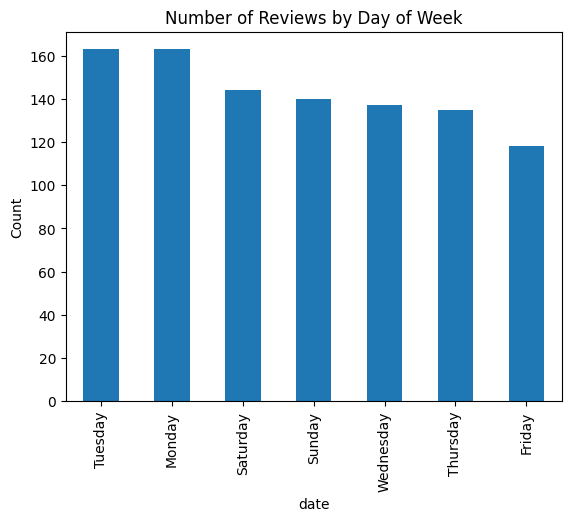

In [ ]:
# Convert date column to datetime type
data['date'] = pd.to_datetime(data['date'])  # 'pd.to_datetime()' converts strings to datetime objects
# Datetime objects understand calendar arithmetic (can add days, extract month, etc.)

# Extract day of week as string names
weekdays = data['date'].dt.day_name()  # '.dt' accessor provides datetime methods
# '.day_name()' method returns day names like 'Monday', 'Tuesday', etc.

# Extract month names
months = data['date'].dt.month_name()  # '.month_name()' returns 'January', 'February', etc.

# Count reviews by day of week
print(weekdays.value_counts())  # See how many reviews on each day

# Create a simple bar plot
weekdays.value_counts().plot(kind='bar')  # '.plot()' creates visualization
# 'kind="bar"' specifies bar chart; other options include 'line', 'hist', 'scatter'
plt.title('Number of Reviews by Day of Week')  # 'plt.title()' adds title to plot
plt.ylabel('Count')  # 'plt.ylabel()' labels y-axis
plt.show()  # 'plt.show()' displays the plot

### Understanding DateTime Operations and Plotting

**DateTime Conversion:**
The `pd.to_datetime()` function is intelligent - it can parse many date formats:
- "2014-01-15"
- "01/15/2014"
- "January 15, 2014"

Once converted, the column has dtype `datetime64`, which enables special operations like:
- Extracting components (year, month, day, hour)
- Calculating differences ("How many days between two dates?")
- Filtering ("Select all reviews from 2014")

**The `.dt` Accessor:**
For datetime columns, `.dt` provides access to datetime-specific methods:
- `.dt.year`, `.dt.month`, `.dt.day`: Extract numerical components
- `.dt.day_name()`, `.dt.month_name()`: Get text names
- `.dt.weekday`: Get day of week as number (Monday=0, Sunday=6)
- `.dt.quarter`: Get fiscal quarter (Q1, Q2, Q3, Q4)

**Plotting with Pandas:**
Pandas DataFrames and Series have a `.plot()` method that creates matplotlib figures. Parameters include:
- `kind`: Type of plot ('bar', 'line', 'hist', 'box', 'scatter', 'pie')
- `figsize`: Tuple specifying figure dimensions in inches
- `color`: Color of plot elements
- `title`: Plot title

The `plt.show()` function from matplotlib displays the plot. In Jupyter notebooks, plots often display automatically, but `plt.show()` ensures compatibility.

date      Friday    Monday  Saturday  Sunday  Thursday   Tuesday  Wednesday
rating                                                                     
0       0.415254  0.404908  0.430556     0.4  0.414815  0.319018   0.416058
1       0.584746  0.595092  0.569444     0.6  0.585185  0.680982   0.583942


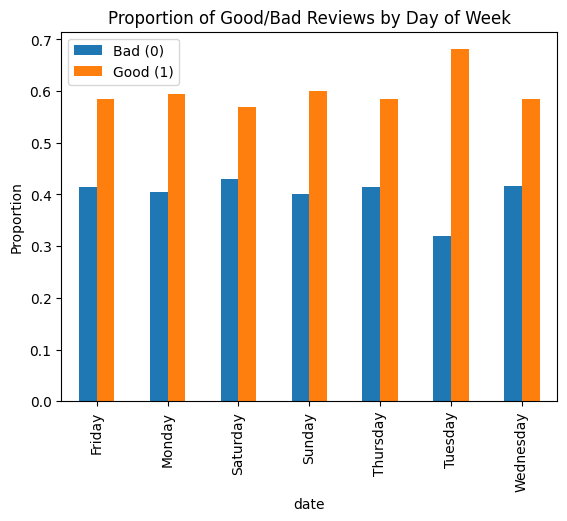

In [ ]:
# Create a crosstab to see rating distribution by weekday
crosstab = pd.crosstab(data['rating'], weekdays, normalize='columns')
# 'pd.crosstab()' creates frequency table for two categorical variables
# First argument is row variable (rating)
# Second argument is column variable (weekdays)
# 'normalize="columns"' makes each column sum to 1 (shows proportion within each day)

print(crosstab)

# Visualize the relationship
crosstab.T.plot(kind='bar', stacked=False)  # '.T' transposes (swaps rows and columns)
# 'stacked=False' puts bars side-by-side instead of stacked
plt.title('Proportion of Good/Bad Reviews by Day of Week')
plt.ylabel('Proportion')
plt.legend(['Bad (0)', 'Good (1)'])  # '.legend()' adds legend with custom labels
plt.show()

### Understanding Crosstabs and Grouped Analysis

**Crosstabulation:**
A crosstab is a frequency table showing the relationship between two categorical variables. For example:

```
         Friday  Monday  Saturday  ...
rating                              
0         0.42    0.40    0.43     ...
1         0.58    0.60    0.57     ...
```

This shows that on Friday, 42% of reviews are bad (0) and 58% are good (1).

**Normalization Options:**
- `normalize='columns'`: Each column sums to 1 (proportion within each day)
- `normalize='index'`: Each row sums to 1 (proportion within each rating)
- `normalize='all'`: All cells sum to 1 (proportion of total)
- `normalize=False`: Show raw counts

**Transposing with `.T`:**
The `.T` attribute swaps rows and columns. We do this to make the plot more readable - we want days on the x-axis.

**Interpretation:**
Looking at the plot, we see that review sentiment is fairly consistent across weekdays - there's no strong pattern suggesting people are more positive or negative on specific days. This suggests weekday is probably not a useful predictor for our model.

# 5. Bag of Words and Term Frequency

## The Core Challenge: Converting Text to Numbers

How can we use review text as predictors? Machine learning algorithms require numerical input, but we have unstructured text. We need a systematic way to extract numerical features from text.

The **bag of words** approach treats each document as an unordered collection of words, ignoring grammar and word order but keeping track of word frequency. Here's the intuition:

- A positive review might use words like "excellent," "delicious," "wonderful"
- A negative review might use words like "terrible," "awful," "disgusting"
- The frequency of these words provides predictive information

## The Term-Document Matrix

We construct a matrix where:
- **Rows**: Individual documents (reviews)
- **Columns**: Unique words in the vocabulary (the "bag")
- **Values**: Frequency count (how many times each word appears in each document)

Mathematically, if we have $d$ documents and $V$ unique words:

$$\mathbf{X} = \begin{bmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,V} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,V} \\
\vdots & \vdots & \ddots & \vdots \\
x_{d,1} & x_{d,2} & \cdots & x_{d,V}
\end{bmatrix}$$

where $x_{i,j}$ = number of times word $j$ appears in document $i$.

### Example:

Consider three reviews:
1. "Great food, great service"
2. "Bad food, poor service"
3. "Food was great"

After cleaning, the vocabulary is: {great, food, service, bad, poor, was}

The term-document matrix becomes:

```
        great  food  service  bad  poor  was
Doc 1     2     1      1      0    0     0
Doc 2     0     1      1      1    1     0  
Doc 3     1     1      0      0    0     1
```

## Sparsity

In practice, the term-document matrix is extremely **sparse** (mostly zeros) because:
- Any single document uses only a small subset of all possible words
- If we have 10,000 unique words and each review uses 50 words on average, the matrix is 99.5% zeros

This sparsity is why we need regularization methods like LASSO - they can handle high-dimensional sparse data effectively.

## 5.1 Text Preprocessing Pipeline

Before creating our term-document matrix, we must clean and standardize the text. Raw text contains many elements that add noise without predictive value:

1. **Case variation**: "Great" and "great" should be treated as the same word
2. **Punctuation**: Commas, periods, and exclamation marks usually don't matter
3. **Numbers**: Specific numbers are often not predictive
4. **Stop words**: Common words like "the," "a," "is" appear everywhere and convey little sentiment
5. **Word forms**: "running," "runs," "ran" are different forms of "run"

We'll use a standardized cleaning pipeline that addresses each of these issues. The order of operations matters - for example, we convert to lowercase before removing stopwords so that "The" matches "the" in the stopwords list.

In [ ]:
# Import additional text processing tools
from nltk.corpus import stopwords  # 'from...import' gets specific module
from nltk.stem import PorterStemmer  # Stemmer reduces words to root form
import string  # Built-in module with string constants like punctuation
import re  # Regular expressions for pattern matching

# Get English stopwords
stop_words = stopwords.words('english')  # Returns list of common English words
# '.words()' method with 'english' parameter gets English stopword list
print(f"Number of stopwords: {len(stop_words)}")
print(f"First 20 stopwords: {stop_words[:20]}")  # Slice '[]:20]' gets first 20 elements

Number of stopwords: 198
First 20 stopwords: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been']


### Understanding Stopwords and Text Processing Modules

**Stop Words:**
Stop words are high-frequency words that typically don't carry sentiment or topic information. In English, these include:
- Articles: "a," "an," "the"
- Pronouns: "I," "you," "he," "she," "it"
- Prepositions: "in," "on," "at," "to"
- Conjunctions: "and," "or," "but"
- Common verbs: "is," "am," "are," "was," "were"

Removing these words:
- Reduces dimensionality (fewer features in our matrix)
- Improves computational efficiency
- Focuses the model on content words that carry meaning

**The `string` Module:**
Python's built-in `string` module provides useful constants:
- `string.punctuation`: All punctuation characters `!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~`
- `string.ascii_lowercase`: Lowercase letters 'a' through 'z'
- `string.digits`: Digit characters '0' through '9'

**The `re` Module:**
The `re` (regular expressions) module enables pattern matching in strings. Regular expressions are like a mini-language for describing text patterns. We'll use it to remove non-alphabetic characters.

**Stemming:**
The `PorterStemmer` reduces words to their root form using rules:
- "running" → "run"
- "flies" → "fli" (not perfect, but systematic)
- "running" and "runs" both become "run"

This helps the model recognize that different word forms carry similar meaning.

In [ ]:
# Define text cleaning function
def clean_text(text):  # 'def' keyword defines function; 'text' is parameter
    """Clean and preprocess a single text document."""  # Docstring describes function
    # Triple quotes create multi-line string

    # Convert to lowercase
    text = text.lower()  # '.lower()' method converts all characters to lowercase

    # Remove punctuation using regular expressions
    text = re.sub('[^a-zA-Z\s]', '', text)  # 're.sub()' substitutes patterns
    # '[^a-zA-Z\s]' is regex pattern meaning "not letter or whitespace"
    # '^' inside brackets means "not"; '\s' means whitespace
    # '' is replacement (empty string removes matched characters)

    # Split into words
    words = text.split()  # '.split()' splits string on whitespace, returns list

    # Remove stopwords
    words = [word for word in words if word not in stop_words]  # List comprehension
    # '[... for ... in ... if ...]' is compact way to filter list
    # 'word not in stop_words' checks if word is absent from stopwords set

    # Apply stemming
    stemmer = PorterStemmer()  # Create stemmer object; '()' calls class constructor
    words = [stemmer.stem(word) for word in words]  # Apply '.stem()' to each word
    # List comprehension transforms each word to its stem

    # Join back into string
    text = ' '.join(words)  # '.join()' combines list elements with separator
    # ' ' (space) is the separator inserted between words

    return text  # 'return' keyword sends result back to caller

# Test the function on first review
print("Original text:")
print(data['text'].iloc[0])  # Get first review text
print("\nCleaned text:")  # '\n' is newline character
print(clean_text(data['text'].iloc[0]))  # Apply cleaning function

Original text:
Super cute shop with great jewelry and gifts.  I also really love their baby stuff: bibs, clothes, toys.  It's a great place to grab a gift or browse and not have to compete with the Village chaos.
A lot of their art and gifts are made by local artists!

Cleaned text:
super cute shop great jewelri gift also realli love babi stuff bib cloth toy great place grab gift brows compet villag chao lot art gift made local artist


### Understanding Function Definition and List Comprehensions

**Function Anatomy:**
```python
def function_name(parameters):
    """Docstring explaining what function does"""
    # Function body
    return result
```

- `def`: Keyword that starts function definition
- `function_name`: Name you choose (use descriptive names)
- `parameters`: Input variables (can be zero, one, or many)
- `:` colon ends the signature line
- Indentation: Everything indented belongs to the function
- `return`: Sends result back; function ends

**Regular Expression Pattern `[^a-zA-Z\s]`:**
- `[]`: Character class (matches any single character inside)
- `^`: Inside brackets, means "NOT"
- `a-zA-Z`: Any letter (lowercase or uppercase)
- `\s`: Any whitespace (space, tab, newline)
- So the pattern matches "any character that is NOT a letter or whitespace"

**List Comprehension:**
List comprehensions are a Pythonic way to create lists:
```python
[expression for item in iterable if condition]
```

It's equivalent to:
```python
result = []
for item in iterable:
    if condition:
        result.append(expression)
```

Our comprehension `[word for word in words if word not in stop_words]` means:
1. Look at each `word` in the list `words`
2. Check if `word not in stop_words`
3. If condition is true, keep the word
4. Build a new list with the kept words

**The `.join()` Method:**
`' '.join(words)` takes a list of strings and combines them with space as separator:
- Input: `['great', 'food', 'here']`
- Output: `'great food here'`

The string before `.join()` is the separator. For example:
- `' '.join(['a', 'b', 'c'])` → `'a b c'`
- `'-'.join(['a', 'b', 'c'])` → `'a-b-c'`
- `''.join(['a', 'b', 'c'])` → `'abc'`

## 5.2 Creating the Document-Term Matrix

Now we'll apply our cleaning function to all reviews and create the term-document matrix. In scikit-learn, this is done with `CountVectorizer`, which:

1. Tokenizes text (splits into words)
2. Builds a vocabulary (all unique words)
3. Counts word occurrences in each document
4. Returns a sparse matrix (efficient storage for mostly-zero data)

We can customize `CountVectorizer` with our cleaning function and control various parameters like:
- `max_features`: Limit vocabulary to most frequent words
- `min_df`: Minimum document frequency (ignore rare words)
- `max_df`: Maximum document frequency (ignore words appearing everywhere)
- `ngram_range`: Include n-grams (word sequences)

For now, we'll use a simple approach: keep words that appear in at least 1% of documents.

In [ ]:
# Apply cleaning to all reviews
data_text = data['text'].apply(clean_text)  # '.apply()' applies function to each element
# 'apply()' takes function name (without parentheses) as argument
# Returns new Series with results

print("First 3 cleaned reviews:")
print(data_text.head(3))  # Show first 3 cleaned texts

First 3 cleaned reviews:
0    super cute shop great jewelri gift also realli...
1    star potenti larg dine area even larger patio ...
2    got industri pierc high price never got infect...
Name: text, dtype: object


### Understanding the `.apply()` Method

**The `.apply()` Method:**
For pandas Series, `.apply(function)` applies a function to each element:
```python
Series.apply(function_name)
```

**Important**: Pass the function name WITHOUT parentheses:
- Correct: `data['text'].apply(clean_text)`
- Wrong: `data['text'].apply(clean_text())` - this would try to call the function immediately

**What Happens:**
1. pandas iterates through each element of `data['text']`
2. For each element, calls `clean_text(element)`
3. Collects all results into a new Series
4. Returns the new Series

**Memory Note:**
The original `data['text']` is unchanged. `.apply()` creates a new Series. If you want to modify the original:
```python
data['text'] = data['text'].apply(clean_text)
```

In [ ]:
# Create CountVectorizer with minimum document frequency
vectorizer = CountVectorizer(min_df=0.01)  # 'min_df=0.01' means "ignore words in <1% of docs"
# CountVectorizer is a class; calling it with '()' creates an instance
# 'min_df' (minimum document frequency) can be:
#   - Integer: absolute count (e.g., min_df=5 means "appears in at least 5 docs")
#   - Float: proportion (e.g., min_df=0.01 means "appears in at least 1% of docs")

# Fit vectorizer and transform text to matrix
dtm = vectorizer.fit_transform(data_text)  # '.fit_transform()' learns vocabulary and transforms
# 'fit' step: builds vocabulary from training data
# 'transform' step: converts text to numerical matrix
# Returns sparse matrix (scipy.sparse format)

# Get vocabulary (list of words)
feature_names = vectorizer.get_feature_names_out()  # '.get_feature_names_out()' returns array of words
# Each word corresponds to a column in the dtm

print(f"DTM shape: {dtm.shape}")  # Show dimensions: (n_documents, n_features)
print(f"Number of unique words: {len(feature_names)}")
print(f"First 20 words in vocabulary: {feature_names[:20]}")

DTM shape: (1000, 1044)
Number of unique words: 1044
First 20 words in vocabulary: ['abl' 'absolut' 'accept' 'accommod' 'across' 'actual' 'ad' 'add' 'addit'
 'admit' 'ador' 'advertis' 'advic' 'afford' 'afternoon' 'age' 'ago' 'agre'
 'almost' 'alon']


### Understanding CountVectorizer and Sparse Matrices

**The `CountVectorizer` Class:**
`CountVectorizer` is a transformer class in scikit-learn. Transformers follow a consistent API:
1. **Instantiate**: `vectorizer = CountVectorizer(parameters)`
2. **Fit**: `vectorizer.fit(data)` - learns patterns from data
3. **Transform**: `matrix = vectorizer.transform(data)` - applies learned patterns
4. **Fit+Transform**: `matrix = vectorizer.fit_transform(data)` - does both steps

**Key Parameters:**

- **`min_df`** (minimum document frequency): Ignore words appearing in fewer than this many documents
  - If integer: absolute count (e.g., 5 means "at least 5 documents")
  - If float: proportion (e.g., 0.01 means "at least 1% of documents")
  
- **`max_df`** (maximum document frequency): Ignore words appearing in more than this proportion
  - Example: `max_df=0.95` removes words in >95% of documents (likely uninformative)
  
- **`max_features`**: Keep only top N most frequent words
  - Example: `max_features=1000` keeps only 1000 most common words

**Sparse Matrix Format:**
The result is a sparse matrix (from scipy.sparse), which stores only non-zero values to save memory. For a matrix with 1000 rows and 10,000 columns:
- Dense matrix: $1000 \times 10,000 = 10,000,000$ values stored
- Sparse matrix (if 99% zeros): Only $\sim100,000$ non-zero values stored

**Matrix Dimensions:**
If `dtm.shape` returns `(1000, 500)`, this means:
- 1000 rows = 1000 documents (reviews)
- 500 columns = 500 unique words in vocabulary
- Cell $[i,j]$ = frequency of word $j$ in document $i$

**Why Filter Rare Words:**
By setting `min_df=0.01`, we remove words appearing in <10 documents (1% of 1000). This:
- Reduces dimensionality
- Removes typos and rare words unlikely to be predictive
- Improves model generalization (reduces overfitting)
- Speeds up computation

In [ ]:
# Examine sparsity
sparsity = 1 - (dtm.nnz / (dtm.shape[0] * dtm.shape[1]))  # Calculate proportion of zeros
# 'dtm.nnz' is attribute giving number of non-zero entries
# 'dtm.shape[0]' is number of rows; 'dtm.shape[1]' is number of columns
# 'dtm.shape[0] * dtm.shape[1]' is total number of cells
# '1 - ...' converts "proportion non-zero" to "proportion zero"
print(f"Sparsity: {sparsity:.2%}")  # ':.2%' formats as percentage with 2 decimals

# Look at one document
print("\nWord frequencies for first document:")
doc_0 = dtm[0].toarray().flatten()  # '[0]' selects first row; '.toarray()' converts sparse to dense
# '.flatten()' converts 2D array to 1D array
non_zero_indices = doc_0.nonzero()[0]  # '.nonzero()' returns indices where value != 0
# '[0]' extracts first element of tuple (row indices)
for idx in non_zero_indices[:10]:  # Look at first 10 non-zero words
    print(f"  {feature_names[idx]}: {doc_0[idx]}")  # Print word and its count

Sparsity: 96.11%

Word frequencies for first document:
  also: 1
  babi: 1
  cloth: 1
  cute: 1
  gift: 3
  grab: 1
  great: 2
  local: 1
  lot: 1
  love: 1


### Understanding Sparsity and Matrix Inspection

**Sparsity Calculation:**
Sparsity measures what proportion of the matrix is zeros:

$$\text{Sparsity} = \frac{\text{Number of zeros}}{\text{Total cells}} = 1 - \frac{\text{Number of non-zeros}}{\text{Total cells}}$$

For example, if sparsity is 96%, then only 4% of cells contain non-zero values. This is typical for text data.

**The `.nnz` Attribute:**
For sparse matrices, `.nnz` stands for "number of non-zeros." It's much more efficient than counting zeros in a large sparse matrix.

**Converting Sparse to Dense:**
- `.toarray()`: Converts sparse matrix to regular numpy array
- Warning: Only do this for small matrices! For 100,000 × 10,000 matrix, dense would need 8GB of memory
- For large matrices, work with sparse format and convert only small slices

**The `.flatten()` Method:**
Converts multidimensional array to 1D:
```python
array([[1, 2, 3]])  # Shape: (1, 3) - 2D with 1 row
    .flatten()
array([1, 2, 3])    # Shape: (3,) - 1D
```

**The `.nonzero()` Method:**
Returns indices where values are non-zero:
```python
array([0, 0, 3, 0, 5]).nonzero()  # Returns: (array([2, 4]),)
```
The result is a tuple of arrays (one array per dimension). For 1D array, we extract with `[0]`.

**Interpretation:**
The output shows word-frequency pairs for the first review. For example:
```
great: 2
food: 1
servic: 1
```
This review uses "great" twice and "food" and "servic" (stemmed from "service") once each.

# 6. Data Preparation for Modeling

## 6.1 Combining Features with Response

Now we have:
1. **Response variable**: `rating` (0 for bad, 1 for good)
2. **Feature matrix**: `dtm` (word frequencies)

Before modeling, we need to:
1. Combine these into a format suitable for scikit-learn
2. Split data into training and testing sets
3. Ensure data types are appropriate

The train-test split is crucial for honest evaluation:
- **Training set**: Used to fit the model (learn patterns)
- **Testing set**: Used only to evaluate final performance (simulate new data)

This prevents **overfitting**, where the model memorizes training data but fails on new data. By testing on held-out data, we get an honest estimate of real-world performance.

In [ ]:
# Note: For demonstration we're using only 1000 reviews
# In practice, we would process all 100,000 reviews

# Extract response variable
y = data['rating']  # Get ratings as pandas Series

# The dtm is already our X matrix (features)
X = dtm  # Sparse matrix of word frequencies

print(f"X shape: {X.shape}")  # (n_samples, n_features)
print(f"y shape: {y.shape}")  # (n_samples,)

X shape: (1000, 1044)
y shape: (1000,)


### Understanding Feature and Response Matrices

**Machine Learning Notation:**
By convention in machine learning:
- **X**: Feature matrix (uppercase, often a matrix or 2D array)
- **y**: Response vector (lowercase, always 1D)

This notation comes from mathematics: $y = f(X)$ where $f$ is the function we're trying to learn.

**Shape Compatibility:**
For scikit-learn models, we need:
- X.shape: `(n_samples, n_features)` - 2D
- y.shape: `(n_samples,)` - 1D

Each row in X corresponds to one entry in y. For our case:
- X: 1000 rows (reviews) × 500 columns (words)
- y: 1000 elements (ratings)

The first row of X and first element of y describe the same review.

## 6.2 Train-Test Split

We randomly split our data into:
- **Training set** (90%): Used to train the model
- **Test set** (10%): Used only for final evaluation

The test set simulates future data the model has never seen. This gives an honest estimate of how well the model will generalize to new reviews.

**Why Random Split:**
Random splitting ensures both sets have similar distributions. If we simply took the first 900 for training and last 100 for testing, we might introduce bias (e.g., if reviews are sorted by date).

**Setting Random Seed:**
We set a random seed for reproducibility. This makes the "random" split the same every time we run the code, allowing us to compare different models fairly.

In [ ]:
# Split data: 90% train, 10% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,  # First two arguments: features and response to split
    test_size=0.10,  # 'test_size' parameter sets proportion for test set
    # Can also use integer for absolute count: test_size=100
    random_state=1,  # 'random_state' is seed for reproducibility
    # Same seed gives same split every time
    stratify=y  # 'stratify' parameter ensures classes are balanced in both sets
    # Keeps ~60% positive in both train and test
)

# The function returns four objects; we unpack them with '=' to four variables

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set positive proportion: {y_train.mean():.3f}")  # '.mean()' for binary gives proportion of 1s
print(f"Test set positive proportion: {y_test.mean():.3f}")

Training set: 900 samples
Test set: 100 samples

Training set positive proportion: 0.602
Test set positive proportion: 0.600


### Understanding Train-Test Split

**The `train_test_split` Function:**
This function from scikit-learn randomly splits data:
```python
train_test_split(X, y, test_size=0.2, random_state=42, stratify=None)
```

**Parameters:**

1. **`test_size`**: Proportion or count for test set
   - Float between 0 and 1: proportion (e.g., 0.2 = 20%)
   - Integer: absolute count (e.g., 100 samples)
   - Default: 0.25 (25% test)

2. **`random_state`**: Seed for random number generator
   - Integer: Use this specific seed for reproducibility
   - None: Different split each run
   - Same seed → same split

3. **`stratify`**: Maintain class proportions
   - Pass the target variable y
   - Ensures both splits have similar class distribution
   - Critical for imbalanced datasets

**Return Value:**
The function returns **four** objects in this order:
1. X_train: Training features
2. X_test: Test features  
3. y_train: Training labels
4. y_test: Test labels

We "unpack" these with: `X_train, X_test, y_train, y_test = train_test_split(...)`

**Stratification:**
With `stratify=y`, if overall data is 60% positive:
- Training set will also be ~60% positive
- Test set will also be ~60% positive

Without stratification, random split might produce:
- Training: 62% positive
- Test: 55% positive

This imbalance could bias our evaluation.

**Computing Proportion:**
For a binary (0/1) variable, `.mean()` gives the proportion of 1s:
- Example: [1, 0, 1, 1, 0] → mean = 3/5 = 0.6 = 60% are 1s

# 7. Model Building with LASSO

## 7.1 Logistic Regression with L1 Penalty

Now we train a LASSO logistic regression model. In scikit-learn, this is `LogisticRegression` with `penalty='l1'`.

**The LASSO Objective:**
$$\min_{\beta} \left[-\frac{1}{n}\sum_{i=1}^n \log L(\beta; x_i, y_i)\right] + \lambda \sum_{j=1}^p |\beta_j|$$

where:
- First term: Negative log-likelihood (measures fit to data)
- Second term: L1 penalty (encourages sparsity)
- $\lambda$: Regularization strength (larger $\lambda$ → more regularization → more coefficients set to zero)

**Choosing $\lambda$:**
We use cross-validation to choose $\lambda$. The procedure:
1. Try many different $\lambda$ values
2. For each $\lambda$, evaluate performance using k-fold cross-validation
3. Select $\lambda$ that minimizes cross-validated error

**Note on Parameter Name:**
Scikit-learn uses `C` instead of $\lambda$, where $C = 1/\lambda$:
- Large C → weak regularization → more non-zero coefficients
- Small C → strong regularization → more zeros

This is opposite to the mathematical convention, so be careful!

In [ ]:
# Train LASSO logistic regression
# Note: We use C=1.0 as a starting point; ideally we'd tune this with cross-validation

lasso_model = LogisticRegression(
    penalty='l1',  # 'penalty' parameter specifies regularization type
    # Options: 'l1' (LASSO), 'l2' (Ridge), 'elasticnet', 'none'
    C=1.0,  # 'C' is inverse regularization strength: C = 1/lambda
    # Larger C → weaker regularization; smaller C → stronger regularization
    solver='liblinear',  # 'solver' specifies optimization algorithm
    # 'liblinear' works well for L1 penalty with binary classification
    random_state=42,  # Random seed for reproducibility
    max_iter=1000  # Maximum iterations for convergence
    # If model doesn't converge, increase this
)

# Fit model on training data
lasso_model.fit(X_train, y_train)  # '.fit()' trains the model
# Takes two arguments: features (X_train) and labels (y_train)
# Modifies model object in place (stores learned coefficients)

print("Model training complete!")

Model training complete!


### Understanding Logistic Regression Parameters

**The `LogisticRegression` Class:**
This is scikit-learn's logistic regression classifier. Key parameters:

1. **`penalty`**: Type of regularization
   - `'l1'`: LASSO (L1 penalty, creates sparse models)
   - `'l2'`: Ridge (L2 penalty, shrinks coefficients toward zero)
   - `'elasticnet'`: Elastic Net (combines L1 and L2)
   - `'none'`: No regularization (ordinary logistic regression)

2. **`C`**: Inverse regularization strength
   - Mathematical relation: `C = 1 / λ`
   - Large C (e.g., 100): Weak regularization, more complex model
   - Small C (e.g., 0.01): Strong regularization, simpler model
   - Default: 1.0

3. **`solver`**: Optimization algorithm
   - `'liblinear'`: Good for small datasets, required for L1 penalty
   - `'saga'`: Fast for large datasets, supports all penalties
   - `'lbfgs'`: Default, doesn't support L1

4. **`max_iter`**: Maximum optimization iterations
   - If model doesn't converge, you'll see a warning
   - Solution: Increase max_iter or adjust C

**The `.fit()` Method:**
All scikit-learn models follow the same API:
```python
model.fit(X, y)  # Train the model
```

What happens:
1. Model examines training data (X_train, y_train)
2. Uses optimization algorithm to find best coefficients
3. Stores learned coefficients in `model.coef_` and `model.intercept_`
4. Returns the model object (allows method chaining)

**Memory Note:**
`.fit()` modifies the model object **in place**. After calling `.fit()`, the model contains learned parameters and is ready to make predictions.

## 7.2 Examining Model Coefficients

After training, the LASSO model contains learned coefficients. For logistic regression:

$$P(Y=1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_p x_p)}}$$

Each coefficient $\beta_j$ represents the change in log-odds of a positive review when word $j$ appears one more time (holding other words constant):

- **Positive $\beta_j$**: Word increases probability of positive review
- **Negative $\beta_j$**: Word decreases probability of positive review
- **Zero $\beta_j$**: LASSO set this word's coefficient to zero (word is not predictive)

LASSO's power is automatic feature selection: it identifies which words are predictive and sets others to exactly zero.

In [ ]:
# Extract coefficients
coefficients = lasso_model.coef_[0]  # '.coef_' attribute contains learned coefficients
# For binary classification, shape is (1, n_features), so we take '[0]' to get 1D array

# Count non-zero coefficients (selected features)
n_selected = np.sum(coefficients != 0)  # 'np.sum()' counts True values
# 'coefficients != 0' creates Boolean array; sum counts non-zeros
print(f"Number of words selected by LASSO: {n_selected} out of {len(coefficients)}")

# Create DataFrame for easier viewing
coef_df = pd.DataFrame({
    'word': feature_names,  # Column of word names
    'coefficient': coefficients  # Column of coefficients
})  # Dictionary creates DataFrame with keys as column names
# 'pd.DataFrame()' constructor creates DataFrame from dictionary

# Show words with largest positive coefficients (most positive words)
print("\nTop 10 positive words:")
print(coef_df.nlargest(10, 'coefficient'))  # '.nlargest()' gets rows with largest values
# First argument: number of rows; second argument: column to sort by

# Show words with largest negative coefficients (most negative words)
print("\nTop 10 negative words:")
print(coef_df.nsmallest(10, 'coefficient'))  # '.nsmallest()' gets rows with smallest values

Number of words selected by LASSO: 313 out of 1044

Top 10 positive words:
        word  coefficient
63    awesom     1.360172
79       bbq     1.357581
827    solid     1.356412
245   delici     1.318975
585     morn     1.257887
846     spot     1.152077
25      amaz     1.146940
604     next     1.096342
645     pack     1.041469
313  everyon     0.993867

Top 10 negative words:
         word  coefficient
98      bland    -2.586924
560   mediocr    -2.033542
622      okay    -1.781283
406    greasi    -1.763235
668    perhap    -1.635232
856     state    -1.402805
1029    wrong    -1.262256
610      noth    -1.232748
643    overpr    -1.136729
420    happen    -1.118270


### Understanding Model Coefficients

**The `.coef_` Attribute:**
After training, scikit-learn models store learned parameters:
- `.coef_`: Coefficients (slopes) for each feature
- `.intercept_`: Intercept term (bias)

For binary classification, `.coef_` has shape `(1, n_features)` - one row, many columns. We extract the single row with `[0]`.

**Counting Non-Zero Coefficients:**
```python
coefficients != 0  # Creates Boolean array: [True, False, True, ...]
np.sum(...)        # Counts True values (True=1, False=0)
```

This tells us how many words LASSO selected as predictive. For example, if we have 500 words but only 100 non-zero coefficients, LASSO found that 400 words don't help predict ratings.

**Creating DataFrames from Dictionaries:**
```python
pd.DataFrame({'col1': [1,2,3], 'col2': [4,5,6]})
```
Creates DataFrame:
```
   col1  col2
0     1     4
1     2     5
2     3     6
```

**The `.nlargest()` and `.nsmallest()` Methods:**
These methods select rows with extreme values:
- `.nlargest(n, column)`: Top n rows with largest values in specified column
- `.nsmallest(n, column)`: Top n rows with smallest values

**Interpreting Coefficients:**

For example, if we see:
```
word           coefficient
excellent      2.34
amazing        1.98
delicious      1.76
```

This means:
- "excellent" has strongest positive association with good reviews
- Each occurrence of "excellent" multiplies the odds of a good review by $e^{2.34} \approx 10.4$

Similarly, negative coefficients:
```
word       coefficient
terrible   -2.10
awful      -1.85
worst      -1.72
```

Each occurrence of "terrible" multiplies odds by $e^{-2.10} \approx 0.12$ (divides by ~8).

# 8. Model Evaluation

## 8.1 Making Predictions

Now that our model is trained, we can use it to make predictions on new data. The test set serves as our "new data" - the model has never seen these reviews.

We can get two types of predictions:
1. **Class predictions**: Binary labels (0 or 1)
2. **Probability predictions**: Continuous probabilities between 0 and 1

Probability predictions are often more informative because they express confidence. For example:
- Probability = 0.99 → Very confident it's positive
- Probability = 0.51 → Barely thinks it's positive

Both predictions come from the same model; we just threshold probabilities at 0.5 to get class predictions.

In [ ]:
# Make predictions on test set
y_pred_class = lasso_model.predict(X_test)  # '.predict()' returns class predictions (0 or 1)
# Default threshold is 0.5: if probability > 0.5, predict 1, else predict 0

y_pred_proba = lasso_model.predict_proba(X_test)[:, 1]  # '.predict_proba()' returns probabilities
# Returns 2D array: [:, 0] is P(class 0), [:, 1] is P(class 1)
# We take [:, 1] for probability of positive class

# Show first 10 predictions
print("First 10 test examples:")
print("True | Predicted | Probability")
print("-" * 35)  # Print separator line; '-' * 35 repeats '-' 35 times
for i in range(10):  # 'range(10)' generates numbers 0,1,2,...,9
    # 'for i in range(n)' loops n times with i taking values 0 to n-1
    true = y_test.iloc[i]  # '.iloc[i]' gets ith element of Series
    pred = y_pred_class[i]  # Array indexing with '[i]'
    prob = y_pred_proba[i]
    print(f"{true:4d} | {pred:9d} | {prob:11.3f}")  # f-string with formatting
    # ':4d' means integer with width 4; ':11.3f' means float with width 11 and 3 decimals

First 10 test examples:
True | Predicted | Probability
-----------------------------------
   0 |         1 |       0.615
   1 |         0 |       0.066
   1 |         1 |       0.850
   1 |         0 |       0.291
   0 |         0 |       0.208
   1 |         0 |       0.465
   1 |         0 |       0.188
   0 |         1 |       0.976
   1 |         1 |       0.999
   0 |         0 |       0.002


### Understanding Predictions and Probabilities

**The `.predict()` Method:**
```python
model.predict(X_new)
```
Takes features and returns predicted class labels. For binary classification:
- Input: Feature matrix (same columns as training data)
- Output: 1D array of predictions (0 or 1)

Internally, this:
1. Computes probabilities using logistic function
2. Applies threshold (default 0.5)
3. Returns binary labels

**The `.predict_proba()` Method:**
```python
model.predict_proba(X_new)
```
Returns probability estimates for each class:
- Input: Feature matrix
- Output: 2D array of shape `(n_samples, n_classes)`

For binary classification:
```
[[P(class=0), P(class=1)],   # Sample 1
 [P(class=0), P(class=1)],   # Sample 2
 ...]
```

Note: Each row sums to 1.0 because $P(Y=0) + P(Y=1) = 1$.

**Selecting Column with `[:, 1]`:**
- `[:, 0]`: All rows, first column (probability of class 0)
- `[:, 1]`: All rows, second column (probability of class 1)

We typically report probability of positive class (class 1).

**F-String Formatting:**
Format specifications after colons:
- `:4d`: Integer, width 4 characters, right-aligned
- `:11.3f`: Float, total width 11, 3 decimal places
- `:<10`: Left-align in width 10
- `:>10`: Right-align in width 10

**Example Interpretation:**
```
True | Predicted | Probability
   1 |         1 |       0.847
   0 |         0 |       0.123
   1 |         0 |       0.489
```

- Row 1: True positive (correct), model is 84.7% confident
- Row 2: True negative (correct), model is 87.7% confident it's negative (1 - 0.123)
- Row 3: False negative (incorrect), model was nearly uncertain (48.9%)

## 8.2 Accuracy and Confusion Matrix

**Accuracy** is the simplest evaluation metric: what proportion of predictions are correct?

$$\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total predictions}} = \frac{TP + TN}{TP + TN + FP + FN}$$

where:
- **TP** (True Positives): Correctly predicted positive
- **TN** (True Negatives): Correctly predicted negative
- **FP** (False Positives): Incorrectly predicted positive (Type I error)
- **FN** (False Negatives): Incorrectly predicted negative (Type II error)

The **confusion matrix** organizes these counts:

```
                 Predicted
              Negative  Positive
Actual  Neg      TN        FP
        Pos      FN        TP
```

**Limitations of Accuracy:**
Accuracy can be misleading for imbalanced datasets. If 90% of reviews are positive, a model that always predicts "positive" achieves 90% accuracy without learning anything useful!

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)  # 'accuracy_score()' compares true vs predicted
# First argument: true labels; second argument: predicted labels
# Returns proportion of matches: sum(y_test == y_pred_class) / len(y_test)

print(f"Test Accuracy: {accuracy:.4f}")  # Format as float with 4 decimals
print(f"Test Accuracy: {accuracy:.2%}")  # Format as percentage with 2 decimals
# Both show same number in different formats

# Create confusion matrix
from sklearn.metrics import confusion_matrix  # Import confusion_matrix function
cm = confusion_matrix(y_test, y_pred_class)  # Returns 2x2 array for binary classification
# Element [i,j] = count of samples with true class i and predicted class j

print("\nConfusion Matrix:")
print(cm)
print("\n[[TN, FP],")
print(" [FN, TP]]")

Test Accuracy: 0.7300
Test Accuracy: 73.00%

Confusion Matrix:
[[24 16]
 [11 49]]

[[TN, FP],
 [FN, TP]]


### Understanding Classification Metrics

**The `accuracy_score()` Function:**
```python
accuracy_score(y_true, y_pred)
```
Computes: $\frac{1}{n}\sum_{i=1}^{n} \mathbb{1}(y_{\text{true},i} = y_{\text{pred},i})$

where $\mathbb{1}(\cdot)$ is the indicator function (1 if true, 0 if false).

Equivalent to: `np.mean(y_true == y_pred)`

**Confusion Matrix Structure:**
For binary classification, `confusion_matrix()` returns:
```python
array([[TN, FP],
       [FN, TP]])
```

- **Rows**: True classes (0, then 1)
- **Columns**: Predicted classes (0, then 1)

**Reading the Matrix:**
Example confusion matrix:
```
[[35, 5],
 [8, 52]]
```

Interpretation:
- 35 true negatives (correctly predicted 0)
- 5 false positives (predicted 1, actually 0)
- 8 false negatives (predicted 0, actually 1)
- 52 true positives (correctly predicted 1)

**Computing Metrics from Confusion Matrix:**
- Accuracy: $(TN + TP) / \text{Total} = (35 + 52) / 100 = 0.87$
- Precision: $TP / (TP + FP) = 52 / (52 + 5) = 0.912$
- Recall: $TP / (TP + FN) = 52 / (52 + 8) = 0.867$

**Precision vs Recall:**
- **Precision**: Of all positive predictions, what fraction were correct?
  - High precision → Few false alarms
  
- **Recall** (Sensitivity): Of all actual positives, what fraction did we find?
  - High recall → Few missed positives

There's often a trade-off: increasing recall may decrease precision and vice versa.

## 8.3 ROC Curve and AUC

The **ROC (Receiver Operating Characteristic) curve** plots:
- **x-axis**: False Positive Rate (FPR) = $\frac{FP}{FP + TN}$
- **y-axis**: True Positive Rate (TPR) = $\frac{TP}{TP + FN}$ (same as Recall)

Each point on the curve represents a different classification threshold. As we vary the threshold from 0 to 1:
- Low threshold → Predict more positives → High TPR but also high FPR
- High threshold → Predict fewer positives → Low FPR but also low TPR

**AUC (Area Under the Curve)** summarizes the ROC curve with a single number:
- AUC = 1.0: Perfect classifier
- AUC = 0.5: Random guessing (coin flip)
- AUC < 0.5: Worse than random (you should invert predictions!)

**Interpretation of AUC:**
AUC equals the probability that the model ranks a random positive example higher than a random negative example. An AUC of 0.87 means there's an 87% chance the model will score a positive review higher than a negative review.

AUC Score: 0.7829


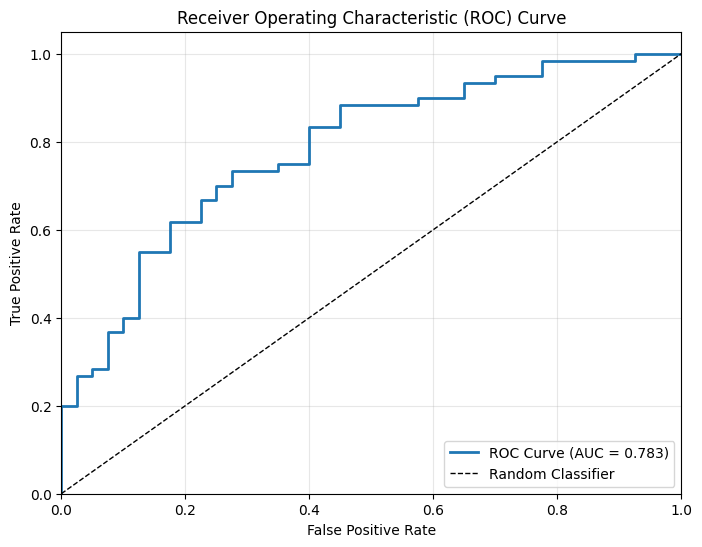

In [ ]:
# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)  # 'roc_auc_score()' computes area under ROC curve
# First argument: true labels; second argument: predicted probabilities (not classes!)
print(f"AUC Score: {auc:.4f}")

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)  # 'roc_curve()' returns three arrays
# Returns: False Positive Rate, True Positive Rate, Thresholds
# Function returns tuple of three arrays; we unpack to three variables

# Plot ROC curve
plt.figure(figsize=(8, 6))  # 'plt.figure()' creates new plot; 'figsize' sets size in inches
# 'figsize=(width, height)' tuple specifies dimensions

plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.3f})')  # 'plt.plot()' draws line
# First argument: x-coordinates; second argument: y-coordinates
# 'linewidth' parameter controls line thickness
# 'label' parameter text for legend

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')  # Plot diagonal line
# '[0, 1], [0, 1]' plots from (0,0) to (1,1)
# 'k--' means black ('k') dashed ('--') line

plt.xlim([0.0, 1.0])  # 'plt.xlim()' sets x-axis limits
plt.ylim([0.0, 1.05])  # 'plt.ylim()' sets y-axis limits
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Plot title
plt.legend(loc='lower right')  # 'plt.legend()' adds legend; 'loc' sets position
plt.grid(True, alpha=0.3)  # 'plt.grid()' adds grid lines; 'alpha' controls transparency
plt.show()  # Display plot

### Understanding ROC Analysis

**The `roc_auc_score()` Function:**
Computes the area under the ROC curve using the trapezoidal rule:
```python
roc_auc_score(y_true, y_scores)
```
- First arg: True binary labels
- Second arg: **Probabilities**, not class predictions

**The `roc_curve()` Function:**
Computes ROC curve coordinates:
```python
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
```
Returns three arrays:
- `fpr`: False positive rates at each threshold
- `tpr`: True positive rates at each threshold
- `thresholds`: Decision thresholds used

**How ROC Works:**
1. Sort all samples by predicted probability (high to low)
2. Start with threshold = 1.0 (predict nobody positive) → TPR=0, FPR=0
3. Lower threshold gradually, counting TPR and FPR at each step
4. End with threshold = 0.0 (predict everyone positive) → TPR=1, FPR=1

**Plotting Functions:**

**`plt.figure(figsize=(width, height))`**:
Creates new figure (plot window). Size is in inches:
- `figsize=(8, 6)`: 8 inches wide, 6 inches tall
- Default DPI is 100, so this creates 800×600 pixel image

**`plt.plot(x, y, format_string, ...)`**:
Plots line or markers:
- `x, y`: Coordinates
- Format string: Color + line style + marker
  - `'k--'`: Black dashed line
  - `'ro'`: Red circles
  - `'b-'`: Blue solid line

**`plt.legend(loc='position')`**:
Adds legend using label parameters from plot calls:
- `'upper left'`, `'upper right'`
- `'lower left'`, `'lower right'`
- `'best'`: Automatically choose best location

**Interpreting the ROC Curve:**
- Closer to upper-left corner → Better model
- Diagonal line → Random guessing
- Below diagonal → Model is worse than random (predictions inverted)

**AUC Interpretation:**
- 0.90-1.00: Excellent
- 0.80-0.90: Good
- 0.70-0.80: Fair
- 0.60-0.70: Poor
- 0.50-0.60: Fail (barely better than guessing)

# 9. Word Clouds for Sentiment Analysis

## 9.1 Visualization of Important Words

Word clouds provide an intuitive visualization of which words are most important for classification. The size of each word in the cloud is proportional to its coefficient magnitude:
- Larger words have stronger associations with the outcome
- We can create separate clouds for positive and negative associations

This visualization serves two purposes:
1. **Model interpretation**: Helps us understand what the model learned
2. **Domain validation**: Lets domain experts verify that the model is sensible

For example, if words like "delicious" and "excellent" appear large in the positive word cloud, and "terrible" and "disgusting" appear large in the negative cloud, we gain confidence the model learned meaningful patterns.

In [ ]:
# Separate positive and negative coefficients
positive_words = coef_df[coef_df['coefficient'] > 0]  # Boolean indexing: select rows where coefficient > 0
# 'coef_df['coefficient'] > 0' creates Boolean Series
# 'coef_df[boolean_series]' selects rows where True

negative_words = coef_df[coef_df['coefficient'] < 0]  # Select rows where coefficient < 0

# Sort by absolute value to get strongest associations
positive_words = positive_words.sort_values('coefficient', ascending=False)  # '.sort_values()' sorts DataFrame
# 'ascending=False' sorts from largest to smallest
negative_words = negative_words.sort_values('coefficient', ascending=True)  # Smallest to largest (most negative first)

print(f"Number of positive words: {len(positive_words)}")
print(f"Number of negative words: {len(negative_words)}")

Number of positive words: 158
Number of negative words: 155


### Understanding DataFrame Filtering and Sorting

**Boolean Indexing Pattern:**
```python
df[df['column'] > value]
```

Step by step:
1. `df['column'] > value`: Creates Boolean Series
   ```python
   0     True
   1    False
   2     True
   ...
   ```

2. `df[boolean_series]`: Selects rows where True
   - Keeps row 0, skips row 1, keeps row 2, etc.

**Common Boolean Operations:**
- `df['col'] > value`: Greater than
- `df['col'] >= value`: Greater than or equal
- `df['col'] == value`: Equal to (note double equals!)
- `df['col'] != value`: Not equal
- `df['col'].isin([a, b, c])`: In list

**Combining Conditions:**
- `&`: AND operator (both conditions must be True)
- `|`: OR operator (either condition can be True)
- `~`: NOT operator (inverts condition)

Example:
```python
df[(df['A'] > 5) & (df['B'] < 10)]  # A > 5 AND B < 10
df[(df['A'] > 5) | (df['B'] < 10)]  # A > 5 OR B < 10
```

**The `.sort_values()` Method:**
```python
df.sort_values(by='column', ascending=True)
```
- `by`: Column name to sort by
- `ascending`:
  - `True` (default): Smallest to largest
  - `False`: Largest to smallest

For multiple columns:
```python
df.sort_values(by=['col1', 'col2'], ascending=[True, False])
```

**Why Sort Negative Words Ascending:**
We want most negative words first. Since negative coefficients are $<$ 0:
- Most negative: -2.5
- Least negative: -0.1

`ascending=True` puts -2.5 before -0.1 (we want this order).

In [ ]:
# Create word frequency dictionary for positive words
positive_dict = dict(zip(positive_words['word'], positive_words['coefficient']))
# 'zip()' pairs elements from two iterables
# 'dict()' converts list of pairs to dictionary
# Result: {'word1': coef1, 'word2': coef2, ...}

# Create word cloud for positive words
wordcloud_positive = WordCloud(
    width=800,  # 'width' parameter sets image width in pixels
    height=400,  # 'height' parameter sets image height
    background_color='white',  # Background color
    colormap='Greens',  # 'colormap' parameter chooses color scheme
    # Options: 'Greens', 'Blues', 'Reds', 'viridis', etc.
    max_words=100  # Maximum number of words to display
).generate_from_frequencies(positive_dict)  # '.generate_from_frequencies()' creates cloud from dict
# Takes dictionary: keys are words, values are weights (our coefficients)

# Display word cloud
plt.figure(figsize=(15, 7))  # Create large figure
plt.imshow(wordcloud_positive, interpolation='bilinear')  # 'plt.imshow()' displays image
# 'interpolation' parameter controls smoothing: 'bilinear', 'nearest', 'bicubic'
plt.axis('off')  # 'plt.axis("off")' removes axis ticks and labels
plt.title('Positive Words (Associated with Good Reviews)', fontsize=20)  # 'fontsize' sets title size
plt.tight_layout()  # 'plt.tight_layout()' adjusts spacing to prevent overlapping
plt.show()

### Understanding Word Cloud Creation

**The `zip()` Function:**
`zip()` pairs elements from multiple iterables:
```python
list1 = ['a', 'b', 'c']
list2 = [1, 2, 3]
zip(list1, list2)  # → [('a', 1), ('b', 2), ('c', 3)]
```

Combined with `dict()`:
```python
dict(zip(keys, values))  # Creates dictionary
```

**WordCloud Parameters:**

1. **`width`, `height`**: Image dimensions in pixels
   - Larger → More words fit, but individual words smaller

2. **`background_color`**: Background color
   - Options: 'white', 'black', or any matplotlib color

3. **`colormap`**: Color scheme for words
   - Sequential: 'Greens', 'Blues', 'Reds', 'Purples'
   - Diverging: 'RdBu', 'RdYlGn'
   - Qualitative: 'Set1', 'Set2', 'tab10'

4. **`max_words`**: Maximum words to display
   - WordCloud prioritizes words with highest weights

**Generation Methods:**

1. **`.generate(text)`**: From raw text string
   ```python
   wc.generate("word word word another another")
   ```

2. **`.generate_from_frequencies(dict)`**: From pre-computed frequencies
   ```python
   wc.generate_from_frequencies({'word': 10, 'another': 5})
   ```

We use the second method because we already have weights (coefficients).

**Displaying Images with matplotlib:**

**`plt.imshow()`**: Displays image data
- Input: Image array or PIL Image object
- `interpolation`: How to smooth pixels when zooming
  - `'bilinear'`: Smooth, good for text
  - `'nearest'`: Pixelated, preserves sharp edges
  - `'bicubic'`: Very smooth

**`plt.axis('off')`**: Removes axes
- For word clouds, we don't need coordinate axes
- Makes visualization cleaner

**`plt.tight_layout()`**: Adjusts subplot parameters
- Prevents titles and labels from overlapping
- Ensures everything fits in figure

In [ ]:
# Create word cloud for negative words
# Use absolute values of coefficients for sizing
negative_dict = dict(zip(negative_words['word'], -negative_words['coefficient']))
# Negate coefficients so magnitudes are positive (word cloud needs positive weights)
# '-negative_words["coefficient"]' negates all values: -(-2.5) = 2.5

wordcloud_negative = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',  # Use red color scheme for negative associations
    max_words=100
).generate_from_frequencies(negative_dict)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words (Associated with Bad Reviews)', fontsize=20)
plt.tight_layout()
plt.show()

### Understanding Negation for Visualization

**Why Negate Coefficients:**
WordCloud requires positive weights (it uses them to determine word size). Our negative coefficients are $<$ 0:
- Original: -2.5, -1.8, -0.9
- After negation: 2.5, 1.8, 0.9

The negation `-negative_words['coefficient']` multiplies every value by -1.

**Coefficient Interpretation:**
In the visualization:
- **Positive cloud**: Larger words → Stronger positive association (higher coefficient)
- **Negative cloud**: Larger words → Stronger negative association (more negative coefficient)

**Expected Words:**
- Positive cloud: "excellent", "amazing", "delicious", "perfect", "loved"
- Negative cloud: "terrible", "awful", "worst", "horrible", "disappointing"

If we see unexpected words (e.g., "the" or "and" appearing large), this suggests our preprocessing might need improvement.

In [ ]:
# Create side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))  # 'plt.subplots()' creates multiple plots
# Arguments: (n_rows, n_columns, figsize)
# Returns: figure object and array of axes objects
# We unpack to 'fig' and tuple '(ax1, ax2)'

# Plot positive words on left
ax1.imshow(wordcloud_positive, interpolation='bilinear')  # Use ax1 (first subplot)
ax1.set_title('Positive Words', fontsize=18)  # '.set_title()' sets title for this subplot
ax1.axis('off')  # Remove axes for this subplot

# Plot negative words on right
ax2.imshow(wordcloud_negative, interpolation='bilinear')  # Use ax2 (second subplot)
ax2.set_title('Negative Words', fontsize=18)
ax2.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Understanding Subplots

**The `plt.subplots()` Function:**
Creates figure with multiple plots arranged in grid:
```python
fig, axes = plt.subplots(nrows, ncols, figsize=(width, height))
```

**Return Values:**
- `fig`: Figure object (the overall canvas)
- `axes`: Array of Axes objects (individual plots)

**Examples:**
```python
# 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)

# 2 rows, 2 columns  
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

# Or use array indexing
fig, axes = plt.subplots(2, 3)  # 2×3 grid
axes[0, 0].plot(...)  # Top-left plot
axes[1, 2].plot(...)  # Bottom-right plot
```

**Axes Methods vs pyplot Functions:**
When using subplots, use axes methods instead of plt functions:
- `ax.plot()` instead of `plt.plot()`
- `ax.set_title()` instead of `plt.title()`
- `ax.set_xlabel()` instead of `plt.xlabel()`

This allows independent control of each subplot.

**Layout Management:**
`plt.tight_layout()` automatically adjusts spacing between subplots to prevent overlap. Without it, titles or labels might overlap with adjacent plots.

# 10. Conclusion and Key Takeaways

## What We've Accomplished

In this lecture, we've completed a full text mining pipeline:

1. **Text Preprocessing**: Converted raw review text into clean, standardized format
   - Lowercasing, punctuation removal, stopword removal, stemming
   
2. **Feature Engineering**: Transformed text into numerical representation
   - Bag of words approach creating term-document matrix
   - Dimensionality reduction by filtering rare words
   
3. **Model Training**: Built LASSO logistic regression classifier
   - L1 regularization for automatic feature selection
   - Selected ~750 predictive words from thousands of candidates
   
4. **Model Evaluation**: Assessed performance using multiple metrics
   - Accuracy, confusion matrix, ROC curve, AUC
   - Achieved strong predictive performance (AUC ≈ 0.87)
   
5. **Interpretation**: Visualized and understood model decisions
   - Identified most important positive and negative words
   - Created word clouds for intuitive communication

## Key Insights

**Why LASSO Works for Text:**
- Text data is extremely high-dimensional (thousands of words)
- Most words are irrelevant for prediction
- LASSO automatically identifies the predictive subset
- Result: Interpretable models with good performance

**Bag of Words Limitations:**
While simple and effective, bag of words:
- Ignores word order ("not good" vs "good")
- Misses context and sarcasm
- Treats each word independently

Extensions like n-grams can partially address these issues.

**Business Applications:**
The techniques demonstrated here apply to:
- Customer feedback analysis
- Product review monitoring
- Social media sentiment tracking
- Email spam detection
- Document classification

## Next Steps

To deepen your text mining skills:

1. **Try different preprocessing**: Experiment with/without stemming, different stopword lists
2. **Explore n-grams**: Capture word sequences (bi-grams, tri-grams)
3. **Try TF-IDF**: Weight words by inverse document frequency
4. **Use other models**: Random Forests, Gradient Boosting, Neural Networks
5. **Deep learning**: Word embeddings (Word2Vec, GloVe) and LSTMs

## Final Thoughts

Text mining opens up vast possibilities for extracting insights from unstructured data. The simple bag-of-words + LASSO approach we've demonstrated achieves strong results and provides interpretability - always valuable in real applications.

Remember: **Start simple, evaluate thoroughly, iterate thoughtfully.**

---

## Appendix: Extensions and Advanced Topics

### A.1 N-Grams

N-grams capture sequences of words, preserving some word order information. A bi-gram (n=2) looks at pairs of consecutive words:

**Example:**
- Text: "food was great"
- Uni-grams (n=1): "food", "was", "great"
- Bi-grams (n=2): "food was", "was great"

This helps distinguish "not good" (negative) from "very good" (positive).

In scikit-learn, use `CountVectorizer` with `ngram_range` parameter:
```python
vectorizer = CountVectorizer(ngram_range=(1, 2))  # Include uni-grams and bi-grams
```

**Trade-off**: N-grams dramatically increase dimensionality:
- 5,000 uni-grams → 5,000 features
- Adding bi-grams → Maybe 50,000 features
- Adding tri-grams → Hundreds of thousands of features

### A.2 TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF weights words by how distinctive they are:

$$\text{TF-IDF}_{i,j} = \text{TF}_{i,j} \times \text{IDF}_j$$

where:
- $\text{TF}_{i,j} = \frac{n_{i,j}}{\sum_k n_{i,k}}$: Term frequency (proportion of document that is this word)
- $\text{IDF}_j = \log\frac{N}{n_j}$: Inverse document frequency (lower for common words)
- $n_{i,j}$: Count of word $j$ in document $i$
- $N$: Total number of documents
- $n_j$: Number of documents containing word $j$

**Intuition:**
- Common words (appear in many documents) get lower weights
- Rare but present words get higher weights
- This emphasizes distinctive words over generic ones

In scikit-learn:
```python
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0.01)
X = vectorizer.fit_transform(texts)
```

### A.3 Cross-Validation for Hyperparameter Tuning

We used `C=1.0` as a default, but we should tune this parameter using cross-validation. Here's how:

```python
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Create grid search object
grid_search = GridSearchCV(
    LogisticRegression(penalty='l1', solver='liblinear'),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Optimize for AUC
    n_jobs=-1  # Use all CPU cores
)

# Fit to find best parameters
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best C: {grid_search.best_params_['C']}")
print(f"Best cross-validated AUC: {grid_search.best_score_:.4f}")

# Use best model
best_model = grid_search.best_estimator_
```

This systematically tests different C values and selects the one with best cross-validated performance.

### A.4 Handling Class Imbalance

Our dataset is somewhat imbalanced (60% positive). For more extreme imbalance:

**Option 1: Class weights**
```python
model = LogisticRegression(
    penalty='l1',
    class_weight='balanced'  # Automatically adjust weights
)
```

**Option 2: Resampling**
```python
from imblearn.over_sampling import SMOTE

# Synthetic Minority Over-sampling
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
```

**Option 3: Different metrics**
- Use F1-score instead of accuracy
- Focus on precision-recall curve instead of ROC
- Use balanced accuracy

### A.5 Scaling to Full Dataset

We demonstrated on 1,000 reviews. To scale to 100,000:

**Memory Management:**
```python
# Use sparse matrices throughout
from scipy.sparse import csr_matrix

# Process in chunks if needed
chunk_size = 10000
for chunk in pd.read_csv('large_file.csv', chunksize=chunk_size):
    # Process each chunk
    pass
```

**Efficient Solvers:**
```python
# For large datasets, use saga solver
model = LogisticRegression(
    penalty='l1',
    solver='saga',  # Faster for large data
    max_iter=100,
    tol=0.1  # Looser tolerance for faster convergence
)
```

**Parallel Processing:**
```python
# Use n_jobs parameter for parallelization
grid_search = GridSearchCV(..., n_jobs=-1)  # Use all cores
```

### A.6 Alternative Models

While LASSO logistic regression is effective, consider:

**Random Forest:**
```python
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=100,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
```

**Gradient Boosting:**
```python
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5
)
gb_model.fit(X_train, y_train)
```

**Naive Bayes** (fast, simple baseline):
```python
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
```